# Option II - E-Commerce & Retail B2B Case Study

## Import Libaries

In [293]:
# import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

sns.set_theme(style="whitegrid")

## Data Cleaning & Preparation

### Load Data

In [294]:
# import Received Payments Data
received = pd.read_csv('data/Received_Payments_Data.csv', encoding='UTF-8')
received.head()

,RECEIPT_METHOD,CUSTOMER_NAME,CUSTOMER_NUMBER,RECEIPT_DOC_NO,RECEIPT_DATE,CLASS,CURRENCY_CODE,Local Amount,USD Amount,INVOICE_ALLOCATED,INVOICE_CREATION_DATE,DUE_DATE,PAYMENT_TERM,INVOICE_CLASS,INVOICE_CURRENCY_CODE,INVOICE_TYPE
0,WIRE,C EA Corp,37403,1.421000e+10,20-Apr-21,PMT,USD,370990.92,101018.63040,14200000001,2-Nov-20,30-Dec-20,30 Days from EOM,INV,AED,Non Goods
1,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,183750.00,48990.21133,99200000043,29-Dec-20,28-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
2,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99210000003,30-Jan-21,1-Mar-21,30 Days from Inv Date,INV,SAR,Non Goods
3,WIRE,FARO Corp,1409,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000038,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods
4,WIRE,RADW Corp,4003,9.921000e+10,31-Jan-21,PMT,SAR,157500.00,41991.60971,99200000039,15-Dec-20,14-Jan-21,30 Days from Inv Date,INV,SAR,Non Goods


### Refine the Data

In [295]:
# check variable types
received.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93937 entries, 0 to 93936
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RECEIPT_METHOD         93937 non-null  object 
 1   CUSTOMER_NAME          93937 non-null  object 
 2   CUSTOMER_NUMBER        93937 non-null  int64  
 3   RECEIPT_DOC_NO         93908 non-null  float64
 4   RECEIPT_DATE           93937 non-null  object 
 5   CLASS                  93937 non-null  object 
 6   CURRENCY_CODE          93937 non-null  object 
 7   Local Amount           93937 non-null  float64
 8   USD Amount             93937 non-null  float64
 9   INVOICE_ALLOCATED      93937 non-null  object 
 10  INVOICE_CREATION_DATE  93937 non-null  object 
 11  DUE_DATE               93937 non-null  object 
 12  PAYMENT_TERM           93937 non-null  object 
 13  INVOICE_CLASS          93937 non-null  object 
 14  INVOICE_CURRENCY_CODE  93937 non-null  object 
 15  IN

In [296]:
# Remove unecessary columns based on the Data Dictionary
received.drop(inplace=True, columns=[
    'RECEIPT_DOC_NO',  # reference number
    'Local Amount', # use USD amount instead
    'INVOICE_ALLOCATED', # reference number
    'CUSTOMER_NAME', # use CUSTOMER_NUMBER instead
    'CURRENCY_CODE' # we will use the currency of the invoice instead
])

In [297]:
# Remove records with Invoice Value equal to 0
received = received[received['USD Amount'] != 0]

In [298]:
# format date variables
date_cols = ['RECEIPT_DATE', 'INVOICE_CREATION_DATE', 'DUE_DATE']

for col in date_cols:
    received[col] = pd.to_datetime(received[col], format='%d-%b-%y')

In [299]:
# calculate TARGET variable
received['LATE_PAYMENT'] = received.apply(
    lambda x: 
        1 if (x['DUE_DATE'] - x['RECEIPT_DATE']).days < 0 # if Receipt Date is after Due Date then return 1
        else 0
    , axis= 1
)

In [300]:
# Calculate Payment Term in days
received['PAYMENT_TERM_DAYS'] = (received['DUE_DATE'] - received['INVOICE_CREATION_DATE']).dt.days

In [305]:
# assign categorical variables
cate_cols = received.select_dtypes(include=['object']).columns.to_list()

# check the values in the categorical variables
for i in cate_cols:
    print(received[i].value_counts(normalize=True))
    print('\n ------------------------------------------- \n')

RECEIPT_METHOD
WIRE             0.897318
AP/AR Netting    0.052224
CHEQUE           0.037409
other            0.013048
Name: proportion, dtype: float64

 ------------------------------------------- 

PAYMENT_TERM
60 Days from Inv Date    0.212712
30 Days from Inv Date    0.151081
60 Days from EOM         0.134812
30 Days from EOM         0.121764
Immediate Payment        0.112207
15 Days from EOM         0.081165
90 Days from EOM         0.041945
45 Days from Inv Date    0.038250
45 Days from EOM         0.037808
other                    0.031095
90 Days from Inv Date    0.023823
100% Adv Payment         0.013339
Name: proportion, dtype: float64

 ------------------------------------------- 

INVOICE_CURRENCY_CODE
SAR      0.414725
AED      0.346069
USD      0.198134
other    0.041073
Name: proportion, dtype: float64

 ------------------------------------------- 



In [302]:
# remaping some of the categorical values
received['PAYMENT_TERM'] = received['PAYMENT_TERM'].replace({'Immediate' : 'Immediate Payment'})

# binary transform
received['INVOICE_TYPE-GOODS'] = received['INVOICE_TYPE'].map({'Goods' : 1, 'Non Goods' : 0}).astype(int)
received.drop(columns= 'INVOICE_TYPE', inplace=True)

received['INVOICE_CLASS-INV'] = received['INVOICE_CLASS'].map({'INV' : 1, 'CM' : 0, 'DM' : 0}).astype(int)
received.drop(columns= 'INVOICE_CLASS', inplace=True)

# drop feature with 1 value
received.drop(columns= 'CLASS', inplace= True)

In [303]:
# define function to quickly map insignificant values to 'other'
def remove_insignificants(data, threshold = 0.05):
    proportions = data.value_counts(normalize=True)

    # Create a list of categories to keep (above the threshold)
    significant_categories = proportions[proportions > threshold].index.tolist()

    # Create a mapping where significant categories map to themselves and others map to 'Other'
    mapping = {category: (category if category in significant_categories else 'other') for category in data.unique()}

    # Apply the mapping to the DataFrame
    data.replace(mapping, inplace = True)

In [304]:
# reduce the insignificants in the dataset
remove_insignificants(received['RECEIPT_METHOD'], 0.03)
remove_insignificants(received['INVOICE_CURRENCY_CODE'], 0.02)
remove_insignificants(received['PAYMENT_TERM'], 0.01)
remove_insignificants(received['INVOICE_CURRENCY_CODE'], 0.02)

### Check for outliers

In [306]:
num_cols = ['USD Amount', 'PAYMENT_TERM_DAYS']

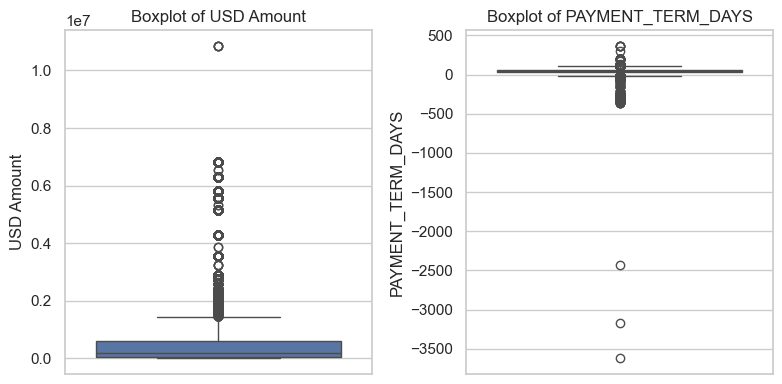

In [309]:
# plot the outliers using boxplot
plt.figure(figsize= (12, 4))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)  # Adjust subplot based on the number of columns
    sns.boxplot(y=received[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
plt.show();

In [308]:
# use quartiles to remove outliers
received['USD Amount'].describe(percentiles=[.05, .1, .25, .5, .75, .9, .95, .97, .99]).astype(int)

count       92811
mean       537645
std        954807
min             1
5%           2572
10%          7829
25%         40452
50%        191287
75%        599613
90%       1257455
95%       2101629
97%       2771599
99%       5814128
max      10849828
Name: USD Amount, dtype: int32

> There are outliers in the 'USD Amount' that will have negative impact on the model's performance

In [310]:
# use quartiles to remove outliers
received['PAYMENT_TERM_DAYS'].describe(percentiles=[.05, .1, .25, .5, .75, .9, .95, .97, .99]).astype(int)

count    92811
mean        45
std         34
min      -3622
5%           0
10%          0
25%         30
50%         45
75%         60
90%         81
95%         90
97%         97
99%        111
max        365
Name: PAYMENT_TERM_DAYS, dtype: int32

> Negative Payment Term indicate errors. Also need to be removed

In [311]:
# remove the outliers base on the quantile 95%
received = received[
    (received['PAYMENT_TERM_DAYS'] <= received['PAYMENT_TERM_DAYS'].quantile(0.95)) 
    & (received['PAYMENT_TERM_DAYS'] >= received['PAYMENT_TERM_DAYS'].quantile(0.05))
]

In [312]:
# drop the original PAYMENT_TERM column
received.drop(columns= 'PAYMENT_TERM', inplace=True)

In [313]:
# re-assign categorical variables
cate_cols = received.select_dtypes(include=['object']).columns.to_list()

## Clustering on Customer-level

#### Prepare customer-level data

In [314]:
# calculate how early the payment was
received['DAYS_EARLY'] = (received['DUE_DATE'] - received['RECEIPT_DATE']).dt.days

# check outliers
received['DAYS_EARLY'].describe(percentiles=[.01, .02, .05, .1, .25, .5, .75, .9, .95, .97, .99]).astype(int)

count    85955
mean       -66
std        193
min      -2154
1%       -1018
2%        -836
5%        -458
10%       -121
25%        -44
50%        -10
75%          4
90%         15
95%         26
97%         34
99%         53
max        161
Name: DAYS_EARLY, dtype: int32

In [315]:
# late than 1 year will be considered the same
received['DAYS_EARLY_CAPPED'] = received['DAYS_EARLY'].clip(lower=-365, upper=60)

In [316]:
# calculate the average and standard deviation of each Customer
## the average days early indicates how on time the customer paid their payments
## the standard deviation indicates how consistent the customer was in making payments
customers = received.groupby('CUSTOMER_NUMBER').agg({'DAYS_EARLY_CAPPED': ['mean', 'std']}).fillna(0)
customers.reset_index(inplace=True)
customers.columns = ['CUSTOMER_NUMBER', 'AVG_DAYS_EARLY_CAPPED', 'STD_DAYS_EARLY_CAPPED']
customers.head()

,CUSTOMER_NUMBER,AVG_DAYS_EARLY_CAPPED,STD_DAYS_EARLY_CAPPED
0,1044,-43.136516,73.182308
1,1076,-10.664000,27.722689
2,1146,-110.100000,146.279243
3,1154,-32.731183,76.718732
4,1192,-61.846154,19.120026


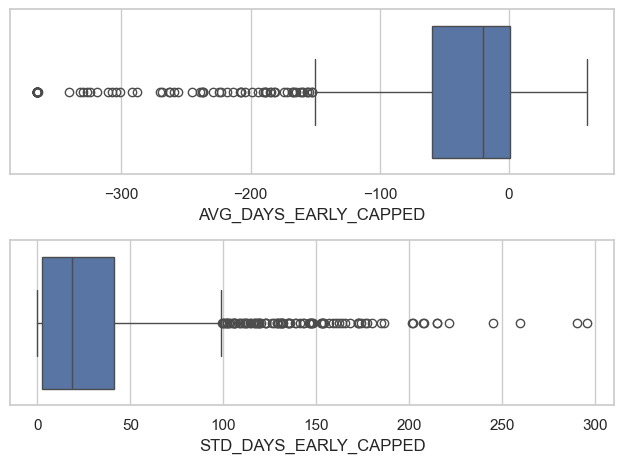

In [319]:
# plot the outliers using boxplot
plt.subplot(2, 1, 1)
sns.boxplot(customers['AVG_DAYS_EARLY_CAPPED'], orient= 'h')
plt.subplot(2, 1, 2)
sns.boxplot(customers['STD_DAYS_EARLY_CAPPED'], orient= 'h')
plt.tight_layout()
plt.show()

In [318]:
# pick out the outliers customers
customers_inliers = customers[
    (customers['AVG_DAYS_EARLY_CAPPED'] > -150) 
    & (customers['STD_DAYS_EARLY_CAPPED'] < 100)
    ]
df_clustering = customers_inliers[['AVG_DAYS_EARLY_CAPPED', 'STD_DAYS_EARLY_CAPPED']]

#### Scaling

In [320]:
# instantiate the scaler
scaler = StandardScaler()

# fit transform the data
df_scaled =  scaler.fit_transform(df_clustering)
df_scaled = pd.DataFrame(df_scaled, columns=['AVG_DAYS_EARLY_CAPPED', 'STD_DAYS_EARLY_CAPPED'])
df_scaled.head()

,AVG_DAYS_EARLY_CAPPED,STD_DAYS_EARLY_CAPPED
0,-0.600077,2.294182
1,0.234327,0.258608
2,-0.332705,2.452535
3,-1.080835,-0.126599
4,-0.687395,3.470142


#### Hierarchical Clustering

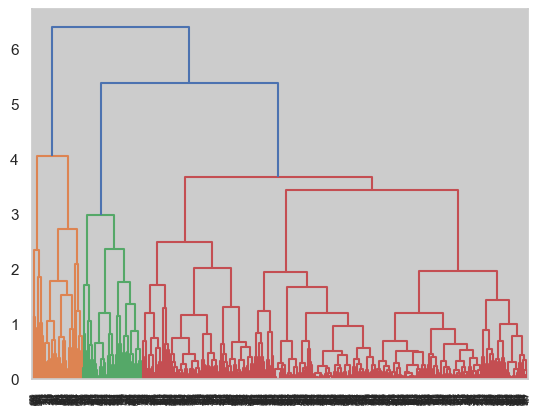

In [321]:
# hierarchical Clustering using Complete Linkage
mergings = linkage(df_scaled[['AVG_DAYS_EARLY_CAPPED', 'STD_DAYS_EARLY_CAPPED']], method="complete", metric="euclidean")
dendrogram(mergings)
plt.show()

In [322]:
# cut at 4 clusters
clusters_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )

# asign clusters labels
customers_inliers.loc[:, 'SEGMENT_ID'] = clusters_labels.copy()
customers_inliers.head()

C:\Users\Liem\AppData\Local\Temp\ipykernel_14916\1566788971.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customers_inliers.loc[:, 'SEGMENT_ID'] = clusters_labels.copy()


,CUSTOMER_NUMBER,AVG_DAYS_EARLY_CAPPED,STD_DAYS_EARLY_CAPPED,SEGMENT_ID
0,1044,-43.136516,73.182308,0
1,1076,-10.664000,27.722689,1
3,1154,-32.731183,76.718732,0
4,1192,-61.846154,19.120026,1
5,1198,-46.534653,99.444514,0


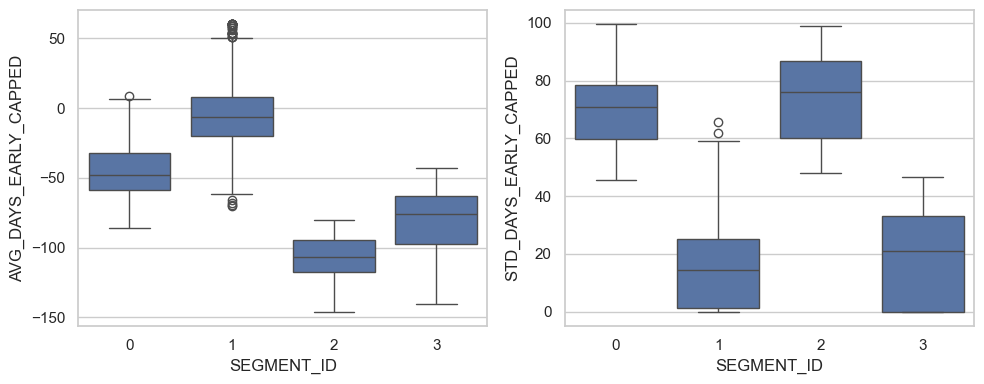

In [323]:
# plot the mean of each Hierarchical cluster
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(x='SEGMENT_ID', y='AVG_DAYS_EARLY_CAPPED', data=customers_inliers, ax=axs[0])
sns.boxplot(x='SEGMENT_ID', y='STD_DAYS_EARLY_CAPPED', data=customers_inliers, ax=axs[1])
plt.tight_layout()

> We have ourselve 4 customers segments with different characteristics:
- `SEGMENT_ID` 0 : Customers who make very late payments, with inconsistent late payment durations.
- `SEGMENT_ID` 1 : Customers who consistently make on-time payments.
- `SEGMENT_ID` 2 : Customers who are kinda late, and have inconsistent late payment durations.
- `SEGMENT_ID` 3 : Customers who consistently make late payments.

In [327]:
# merge the clusters labels back into customers data
customers = customers.merge(customers_inliers[['CUSTOMER_NUMBER', 'SEGMENT_ID']], how='left', on='CUSTOMER_NUMBER')

# fill the outliers with segment_id = 0, since they have the same characteristics (late for for than 150 days, with high STD)
customers['SEGMENT_ID'] = customers['SEGMENT_ID'].fillna(0)

# correct the variable type
customers['SEGMENT_ID'] = customers['SEGMENT_ID'].astype(int)
customers.head()

,CUSTOMER_NUMBER,AVG_DAYS_EARLY_CAPPED,STD_DAYS_EARLY_CAPPED,SEGMENT_ID
0,1044,-43.136516,73.182308,0
1,1076,-10.664000,27.722689,1
2,1146,-110.100000,146.279243,0
3,1154,-32.731183,76.718732,0
4,1192,-61.846154,19.120026,1


In [329]:
# use the segmentation data to add segment_id to the received data
received = received.merge(customers[['CUSTOMER_NUMBER', 'SEGMENT_ID']], how='left', on='CUSTOMER_NUMBER')

## EDA

In [324]:
received.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85955 entries, 0 to 93936
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   RECEIPT_METHOD         85955 non-null  object        
 1   CUSTOMER_NUMBER        85955 non-null  int64         
 2   RECEIPT_DATE           85955 non-null  datetime64[ns]
 3   USD Amount             85955 non-null  float64       
 4   INVOICE_CREATION_DATE  85955 non-null  datetime64[ns]
 5   DUE_DATE               85955 non-null  datetime64[ns]
 6   INVOICE_CURRENCY_CODE  85955 non-null  object        
 7   LATE_PAYMENT           85955 non-null  int64         
 8   PAYMENT_TERM_DAYS      85955 non-null  int64         
 9   INVOICE_TYPE-GOODS     85955 non-null  int32         
 10  INVOICE_CLASS-INV      85955 non-null  int32         
 11  DAYS_EARLY             85955 non-null  int64         
 12  DAYS_EARLY_CAPPED      85955 non-null  int64         
dtypes: dat

### Target Variable

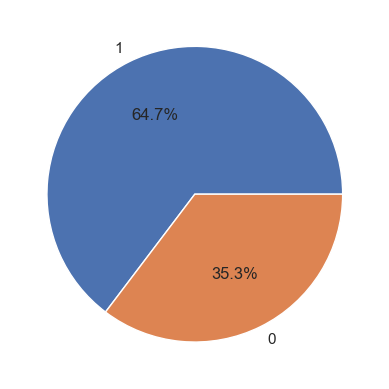

In [325]:
# plot taget variable
sns.set_theme(style="whitegrid")
plt.pie(received['LATE_PAYMENT'].value_counts(), labels= received['LATE_PAYMENT'].value_counts().index, autopct='%1.1f%%')
plt.show()

> About 2/3 payments are Late!

### Categoricals Variables

In [330]:
# add segment_id to our list of categorical variables
cate_cols.append('SEGMENT_ID')
received['SEGMENT_ID'] = received['SEGMENT_ID'].astype('category')

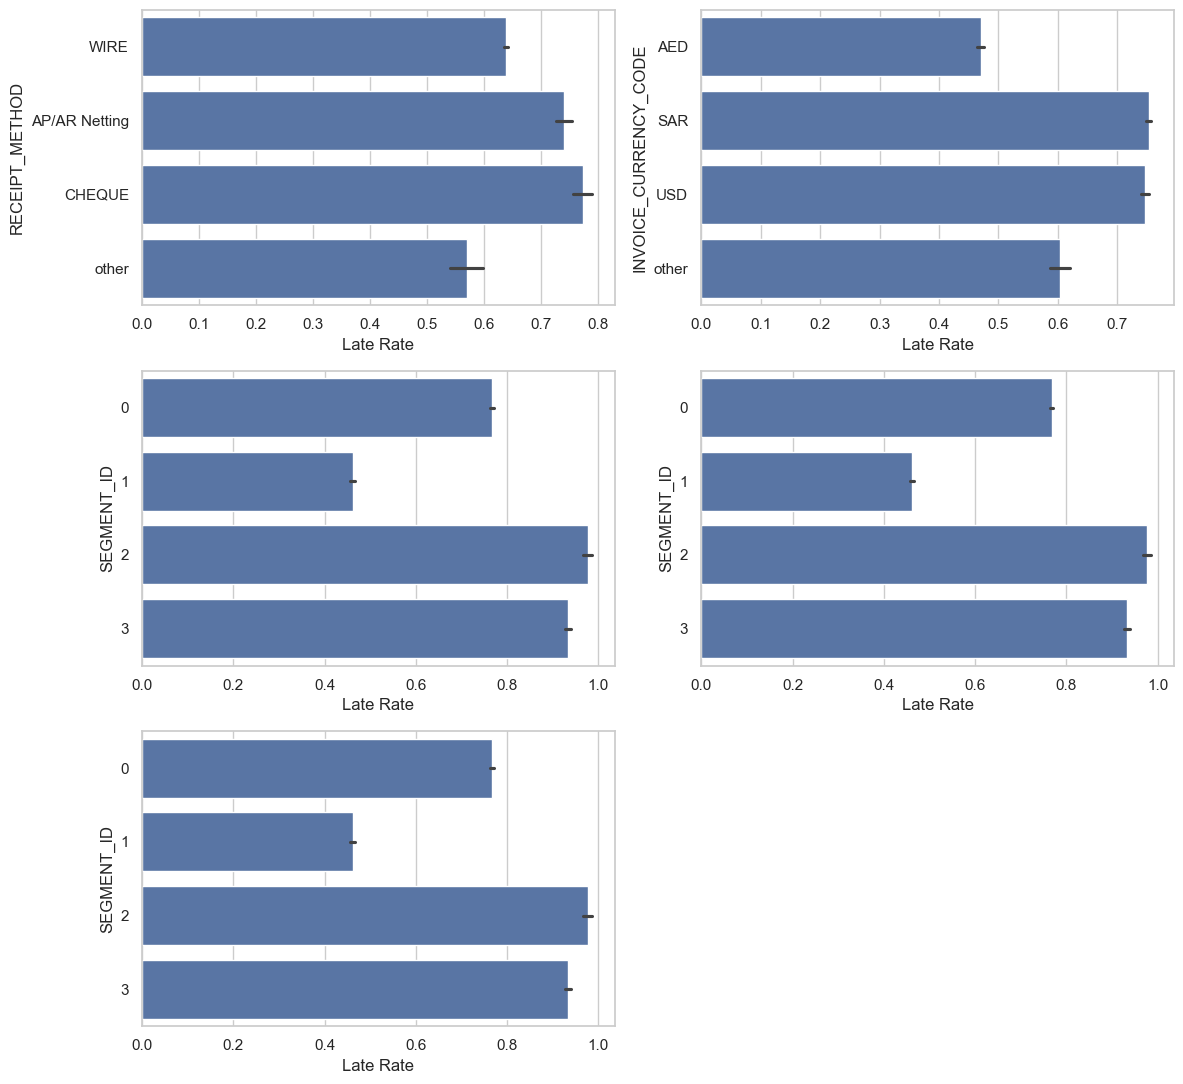

In [331]:
# Lets check the average Late rate of categorical variables
plt.figure(figsize=(12,11))
for i in range(len(cate_cols)):
    plt.subplot(3, 2, i+1)
    sns.barplot(data= received, y= cate_cols[i], x= 'LATE_PAYMENT')
    plt.xlabel('Late Rate')
    plt.ylabel(cate_cols[i])
plt.tight_layout()
plt.show();

> Insights on the Categoricals Variables Analysis:
- Payments with ***"Cheque"*** **payment method** have the highest chance of being late.
- **Invoice's currency** with ***"USD"*** and ***"SAR"*** **currency** have much higher change of being late, compared to ***"AED"*** and ***"other"***.
- Customers in **SEGMENT_ID** "3" have very high chance of paying late, while customers in **SEGMENT_ID** "1" are less likely to.

### Numerical Variables

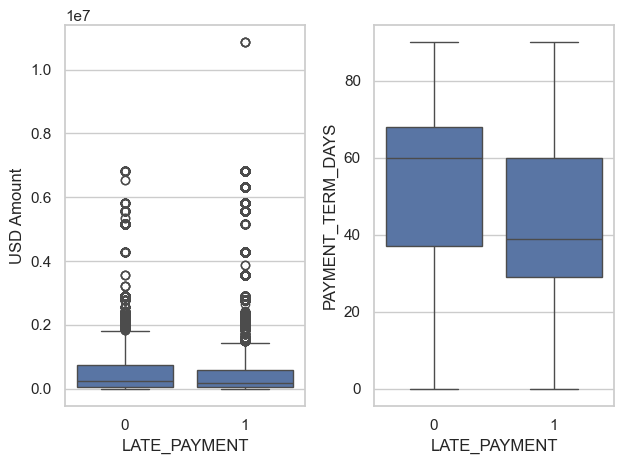

In [332]:
# plot payment value
plt.subplot(1, 2, 1)
sns.boxplot(x='LATE_PAYMENT', y='USD Amount', data=received)
plt.subplot(1, 2, 2)
sns.boxplot(x='LATE_PAYMENT', y='PAYMENT_TERM_DAYS', data=received)
plt.tight_layout()

> The payment was made on time or late, have nothing to do with the payment value in USD.

> The longer the term (in days), the less likely of the payment to be late.

In [333]:
received['INVOICE_CREATION_DATE'].dt.year.value_counts()

INVOICE_CREATION_DATE
2021    54302
2020    26996
2019     2615
2018     1707
2017      199
2016      135
2015        1
Name: count, dtype: int64

<Axes: xlabel='DUE_MONTH', ylabel='LATE_PAYMENT'>

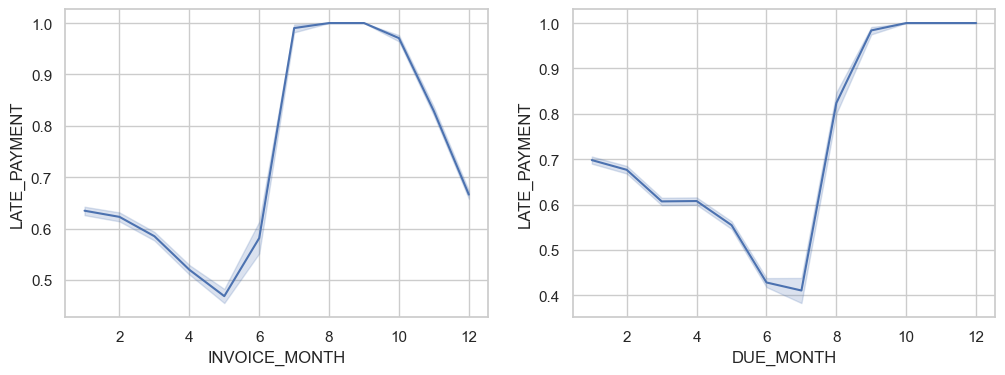

In [334]:
# analyze Transaction Date to see if there are any patterns
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
received['INVOICE_MONTH'] = received['INVOICE_CREATION_DATE'].dt.month
sns.lineplot(x='INVOICE_MONTH', y='LATE_PAYMENT', data=received)

# analyze Transaction Date to see if there are any patterns
received['DUE_MONTH'] = received['DUE_DATE'].dt.month
plt.subplot(1,2,2)
sns.lineplot(x='DUE_MONTH', y='LATE_PAYMENT', data=received)

> Insights on Invoice Creation Date and Due Date:
- Seems like during August (for Invoice Month) and at the end of the year (for Due Month), the chane of a late payment is significantly higher. 
- Middle of the year is more likely to receive payment on time.

<Axes: xlabel='INVOICE_CLASS-INV', ylabel='LATE_PAYMENT'>

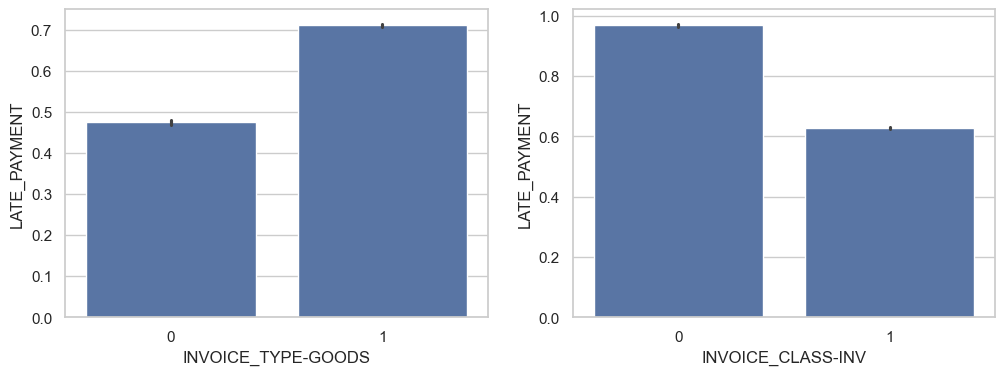

In [335]:
# analyze bi variables
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.barplot(x='INVOICE_TYPE-GOODS', y='LATE_PAYMENT', data=received)

plt.subplot(1, 2, 2)
sns.barplot(x='INVOICE_CLASS-INV', y='LATE_PAYMENT', data=received)

> Insights on the binary variables:
- With **Invoice type** created for ***"physical goods"***, the change of getting a late payment is higher than Invoice created for ***"services"***
- **Invoice classes** ***"Invoice"*** have lower change of a late payment, compared to ***"other"*** classes

## Dummy Creation

In [336]:
# clean up unecessary columns
received.drop(
    inplace=True, 
    columns=['CUSTOMER_NUMBER', 'RECEIPT_DATE', 'INVOICE_CREATION_DATE', 'DUE_DATE', 'DAYS_EARLY', 'DAYS_EARLY_CAPPED']
)

In [337]:
# remove features which doesn't exist in Open Invoice data
received.drop(
    inplace=True, 
    columns=['RECEIPT_METHOD', 'INVOICE_TYPE-GOODS', ]
)

In [338]:
# preview variables before dummy creation
received.head()

,USD Amount,INVOICE_CURRENCY_CODE,LATE_PAYMENT,PAYMENT_TERM_DAYS,INVOICE_CLASS-INV,SEGMENT_ID,INVOICE_MONTH,DUE_MONTH
0,101018.63040,AED,1,58,1,0,11,12
1,48990.21133,SAR,1,30,1,1,12,1
2,41991.60971,SAR,0,30,1,1,1,3
3,41991.60971,SAR,1,30,1,0,12,1
4,41991.60971,SAR,1,30,1,1,12,1


In [339]:
# list of variables to be dummified
dummy_cols = [
    'INVOICE_CURRENCY_CODE',
    'SEGMENT_ID'
]

In [340]:
# Get the dummy variables for categorical variables.
dummies = pd.get_dummies(received[dummy_cols], columns= dummy_cols, drop_first= True, dtype= int)

# merge the dummy variables with the original dataframe
data = pd.concat([received, dummies], axis= 1)
data.drop(dummy_cols, axis= 1, inplace= True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85955 entries, 0 to 85954
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   USD Amount                   85955 non-null  float64
 1   LATE_PAYMENT                 85955 non-null  int64  
 2   PAYMENT_TERM_DAYS            85955 non-null  int64  
 3   INVOICE_CLASS-INV            85955 non-null  int32  
 4   INVOICE_MONTH                85955 non-null  int32  
 5   DUE_MONTH                    85955 non-null  int32  
 6   INVOICE_CURRENCY_CODE_SAR    85955 non-null  int32  
 7   INVOICE_CURRENCY_CODE_USD    85955 non-null  int32  
 8   INVOICE_CURRENCY_CODE_other  85955 non-null  int32  
 9   SEGMENT_ID_1                 85955 non-null  int32  
 10  SEGMENT_ID_2                 85955 non-null  int32  
 11  SEGMENT_ID_3                 85955 non-null  int32  
dtypes: float64(1), int32(9), int64(2)
memory usage: 4.9 MB


## Test-Train split & scaling

In [341]:
# load data to x and y
x= data.drop(columns= 'LATE_PAYMENT')
y= data['LATE_PAYMENT']

In [342]:
# specify the state of randomness
np.random.seed(0)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= 0.7, random_state= 100)

In [343]:
# initiate scaler object
scaler = StandardScaler()

# declare cols that require scaling
scale_cols = ['USD Amount', 'PAYMENT_TERM_DAYS', 'INVOICE_MONTH', 'DUE_MONTH']

# fit the scaler
x_train[scale_cols] = scaler.fit_transform(x_train[scale_cols])
x_train.head()

,USD Amount,PAYMENT_TERM_DAYS,INVOICE_CLASS-INV,INVOICE_MONTH,DUE_MONTH,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_other,SEGMENT_ID_1,SEGMENT_ID_2,SEGMENT_ID_3
55787,6.428074,0.630732,1,1.606394,-0.828131,0,1,0,0,0,0
33915,-0.456388,-0.298173,1,-1.090720,-0.828131,1,0,0,0,0,0
80502,-0.492573,-0.002613,1,-0.600335,0.170366,1,0,0,0,0,0
46327,-0.571990,-0.551511,1,-0.355143,0.170366,0,0,0,1,0,0
5143,-0.555530,-0.467065,1,1.606394,-1.160963,0,0,0,1,0,0


<Axes: >

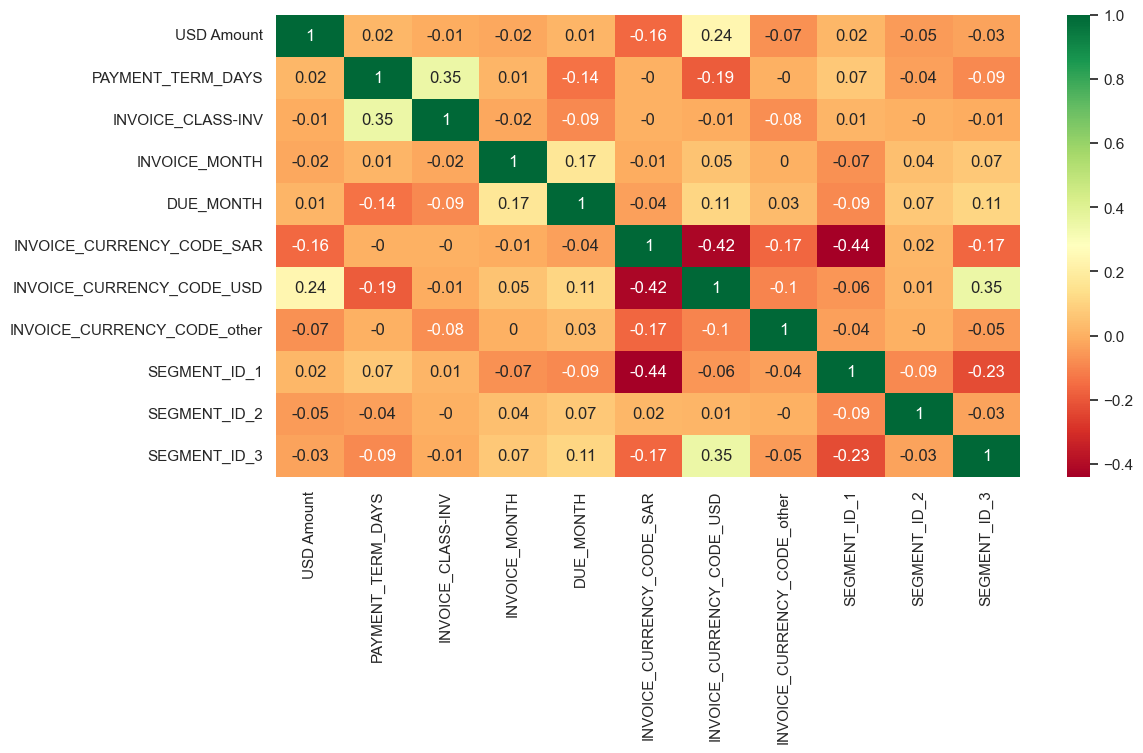

In [344]:
# check the correlation between the variables
plt.figure(figsize= (12, 6))
sns.heatmap(x_train.corr().round(2), annot= True, cmap= 'RdYlGn')

> Seems like SEGMENT_ID_1 can be a high correlation features.

In [170]:
# x_train.drop(columns=['SEGMENT_ID_1'], inplace=True)

## Model Building using Logistic Regression

### Initiate with RFE

In [345]:
# initialise logistic regression model
lr = LogisticRegression()

# use RFE to select top 10 features
rfe = RFE(lr, n_features_to_select= 11)
rfe = rfe.fit(x_train, y_train)

# get the selected features
col = x_train.columns[rfe.support_]
col

Index(['USD Amount', 'PAYMENT_TERM_DAYS', 'INVOICE_CLASS-INV', 'INVOICE_MONTH',
       'DUE_MONTH', 'INVOICE_CURRENCY_CODE_SAR', 'INVOICE_CURRENCY_CODE_USD',
       'INVOICE_CURRENCY_CODE_other', 'SEGMENT_ID_1', 'SEGMENT_ID_2',
       'SEGMENT_ID_3'],
      dtype='object')

### Build First Model

In [346]:
# assessing 1st model using StatsModels
x_train_sm = sm.add_constant(x_train[col])
lrm1 = sm.GLM(y_train, x_train_sm, family = sm.families.Binomial()).fit()
lrm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           LATE_PAYMENT   No. Observations:                60168
Model:                            GLM   Df Residuals:                    60156
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -31039.
Date:                Tue, 03 Dec 2024   Deviance:                       62078.
Time:                        23:50:35   Pearson chi2:                 5.71e+04
No. Iterations:                     7   Pseudo R-squ. (CS):             0.2335
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                           3.1845      0.108     29.548      0.000       2.973       3.396
USD Amount                      0.0100      0.011      0.907      0.364      -0.012       0.032
PAYMENT_TERM_DAYS              -0.6170      0.012    -53.207      0.000      -0.640      -0.594
INVOICE_CLASS-INV              -2.2800      0.105    -21.735      0.000      -2.486      -2.074
INVOICE_MONTH                   0.3673      0.010     35.582      0.000       0.347       0.388
DUE_MONTH                       0.3067      0.012     24.556      0.000       0.282       0.331
INVOICE_CURRENCY_CODE_SAR       0.5291      0.026     20.051      0.000       0.477       0.581
INVOICE_CURRENCY_CODE_USD       0.3954      0.030     13.153      0.000       0.336       0.454
INVOICE_CURRENCY_CODE_other    -0.0582      0.051     -1.146      0.252      -0.158       0.041
SEGMENT_ID_1                   -1.1575      0.024    -48.423      0.000      -1.204      -1.111
SEGMENT_ID_2                    2.0752      0.257      8.071      0.000       1.571       2.579
SEGMENT_ID_3                    1.2398      0.070     17.674      0.000       1.102       1.377
===============================================================================================
"""

In [347]:
# map the actual results with the predicted probabilities
y_train_pred = lrm1.predict(x_train_sm)
y_train_pred_final = pd.concat([y_train, y_train_pred], axis = 1)
y_train_pred_final.columns = ['LATED', 'LATED_PROB']
y_train_pred_final.head()

,LATED,LATED_PROB
55787,1,0.787739
33915,1,0.722799
80502,1,0.779371
46327,0,0.500830
5143,0,0.565529


In [348]:
# calculated the predicted outcome if prob > 0.5
y_train_pred_final['PREDICTED'] = y_train_pred_final.LATED_PROB.map(lambda x: 1 if x > 0.5 else 0)

# Check the accuracy of the first model
accuracy_score(y_train_pred_final.LATED, y_train_pred_final.PREDICTED)

0.7229091876080308

In [349]:
# assessing 1st model using VIFs
vif = pd.DataFrame()
vif['Features'] = x_train[col].columns
vif['VIF'] = [variance_inflation_factor(x_train.values, i) for i in range(x_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif.sort_values(by = "VIF", ascending = False)

,Features,VIF
2,INVOICE_CLASS-INV,5.56
5,INVOICE_CURRENCY_CODE_SAR,2.65
8,SEGMENT_ID_1,2.35
6,INVOICE_CURRENCY_CODE_USD,1.91
10,SEGMENT_ID_3,1.35
1,PAYMENT_TERM_DAYS,1.14
7,INVOICE_CURRENCY_CODE_other,1.11
0,USD Amount,1.10
4,DUE_MONTH,1.07
3,INVOICE_MONTH,1.04


> We got ourself a Logistic Model with 0.72 accuracy!

### Evaluation

In [350]:
# Let's create columns with different probability cutoffs 
numbers = np.arange(0,1,0.05)
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final['LATED_PROB'].map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,LATED,LATED_PROB,PREDICTED,0.0,0.05,0.1,0.15,0.2,0.25,0.3,...,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95
55787,1,0.787739,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,0
33915,1,0.722799,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0
80502,1,0.779371,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,0
46327,0,0.500830,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
5143,0,0.565529,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0


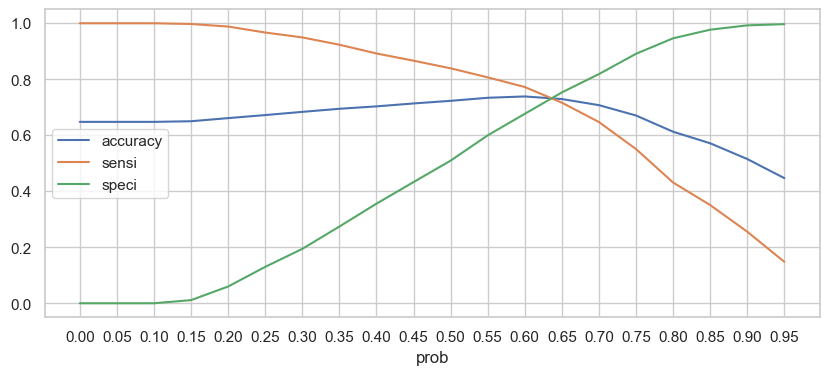

In [351]:
# draw ROC Curve
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
for i in numbers:
    cm1 = confusion_matrix(y_train_pred_final['LATED'], y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
# Let's plot accuracy sensitivity and specificity for various probabilities.    
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'], figsize=(10,4))
plt.xticks(numbers)
plt.show()

In [352]:
# apply the threshold of 0.64
y_train_pred_final['FINAL_PREDICTED'] = y_train_pred_final['LATED_PROB'].map(lambda x: 1 if x > 0.64 else 0)
y_train_pred_final.head()

,LATED,LATED_PROB,PREDICTED,0.0,0.05,0.1,0.15,0.2,0.25,0.3,...,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,FINAL_PREDICTED
55787,1,0.787739,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,1
33915,1,0.722799,1,1,1,1,1,1,1,1,...,1,1,1,1,0,0,0,0,0,1
80502,1,0.779371,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,1
46327,0,0.500830,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5143,0,0.565529,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0


In [353]:
# check accuracy and confusion matrix of the model
print(accuracy_score(y_train_pred_final['LATED'], y_train_pred_final['FINAL_PREDICTED']))
print(confusion_matrix(y_train_pred_final['LATED'], y_train_pred_final['FINAL_PREDICTED']))

0.7313522138013562
[[15684  5508]
 [10656 28320]]


> The accuracy is lower than requires.

## Model Building using Random Forests

### Initiate with a barebone RF model

In [354]:
# load data to x and y
x= data.drop(columns= 'LATE_PAYMENT')
y= data['LATE_PAYMENT']

# specify the state of randomness
np.random.seed(0)
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size= 0.7, random_state= 100)

In [355]:
# build a random forest model with no tuning
rf = RandomForestClassifier(random_state= 100)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=100)

In [356]:
# evaluate the train set
y_train_pred = rf.predict(x_train)
print(accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

0.9620728626512431
              precision    recall  f1-score   support

           0       0.97      0.92      0.94     21192
           1       0.96      0.99      0.97     38976

    accuracy                           0.96     60168
   macro avg       0.96      0.95      0.96     60168
weighted avg       0.96      0.96      0.96     60168



In [357]:
# evaluate the test set
y_test_pred = rf.predict(x_test)
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

0.9168185519835577
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      9166
           1       0.92      0.95      0.94     16621

    accuracy                           0.92     25787
   macro avg       0.91      0.90      0.91     25787
weighted avg       0.92      0.92      0.92     25787



> The scores of our first Random Forest model was drastically increased compare to the previous logistic model.

### Use RandomizedSearchCV for Hyperparameter Tuning

In [358]:
# wild guesses on the params
hyper_params = {
    'n_estimators' : range(50, 400, 50),
    'max_depth' : range(2, 30, 3),
    'min_samples_split' : range(2, 20, 2),
    'min_samples_leaf' : range(1, 10, 2),
    'max_features' : ['auto', 'sqrt', 'log2']
}

In [359]:
# initiate the model
rf_randomsearch = RandomizedSearchCV(
    estimator= RandomForestClassifier(random_state=100),
    param_distributions= hyper_params,
    n_iter=50,
    cv=5,
    verbose=0,
    n_jobs=-1,
    return_train_score=True
)

In [360]:
# fit the model
rf_randomsearch.fit(x_train, y_train)

d:\self-study\upGrad\upGrad-Domain-Oriented-Case-Study\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
65 fits failed with the following error:
Traceback (most recent call last):
  File "d:\self-study\upGrad\upGrad-Domain-Oriented-Case-Study\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\self-study\upGrad\upGrad-Domain-Oriented-Case-Study\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "d:\self-study\upGrad\upGrad-Domain-Oriented-Case-Study\.venv\Lib\site

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': range(2, 30, 3),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': range(1, 10, 2),
                                        'min_samples_split': range(2, 20, 2),
                                        'n_estimators': range(50, 400, 50)},
                   return_train_score=True)

In [361]:
# check the best scores
print("Best score: {}".format(rf_randomsearch.best_score_))
print("Best parameters: {}".format(rf_randomsearch.best_params_))
print("Best estimator: {}".format(rf_randomsearch.best_estimator_))

Best score: 0.9156860984516833
Best parameters: {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 26}
Best estimator: RandomForestClassifier(max_depth=26, n_estimators=150, random_state=100)


### Use GridSearchCV to fine tune the model

In [362]:
# fine tune on the params
hyper_params = {
    'n_estimators' : range(100, 200, 10),
    'max_depth' : range(23, 29, 2),
    'min_samples_split' : range(1, 3, 1),
    'min_samples_leaf' : range(1, 2, 1),
    'max_features' : [2, 5, 1]
}

In [363]:
# initiate the model
rf_gridsearch = GridSearchCV(
    estimator= RandomForestClassifier(random_state=100),
    param_grid= hyper_params,
    cv=5,
    verbose=0,
    n_jobs=-1,
    return_train_score=True
)

In [364]:
# fit the model
rf_gridsearch.fit(x_train, y_train)

d:\self-study\upGrad\upGrad-Domain-Oriented-Case-Study\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
450 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "d:\self-study\upGrad\upGrad-Domain-Oriented-Case-Study\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\self-study\upGrad\upGrad-Domain-Oriented-Case-Study\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "d:\self-study\upGrad\upGrad-Domain-Oriented-Case-Study\.venv\Lib\si

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=100),
             n_jobs=-1,
             param_grid={'max_depth': range(23, 29, 2),
                         'max_features': [2, 5, 1],
                         'min_samples_leaf': range(1, 2),
                         'min_samples_split': range(1, 3),
                         'n_estimators': range(100, 200, 10)},
             return_train_score=True)

In [365]:
# check the best scores
print("Best score: {}".format(rf_gridsearch.best_score_))
print("Best parameters: {}".format(rf_gridsearch.best_params_))
print("Best estimator: {}".format(rf_gridsearch.best_estimator_))

Best score: 0.9167996322671514
Best parameters: {'max_depth': 23, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best estimator: RandomForestClassifier(max_depth=23, max_features=5, n_estimators=150,
                       random_state=100)


In [366]:
# extracting the best Random Forest model
rf_best = rf_gridsearch.best_estimator_

> After fine-tuning the parameters, we have the best estimator with the following params:

In [367]:
rf_best.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 23,
 'max_features': 5,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}

### Evaluation

In [368]:
y_test_pred = rf_best.predict(x_test)
print(accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

0.9184085004071819
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      9166
           1       0.92      0.95      0.94     16621

    accuracy                           0.92     25787
   macro avg       0.92      0.90      0.91     25787
weighted avg       0.92      0.92      0.92     25787



> We have succsessfully built a Random Forest classification, with good evaluation results:
- Good performance on class 1 (Late Payment) with high recall and F1-score. This means that our model can predict most of the late payments.
- High accuracy score on both train and test set, indicates a stable model have been built.

## Predictions on the Open Invoice Data

### Tranform the Open Invoice data into the shape of Received Payments data

In [383]:
# import Open Invoice data
open = pd.read_csv('data/Open_Invoice_data.csv', encoding='UTF-8', encoding_errors='replace')
open.head()

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
0,04-APR-2022 01:07:01,3rd Party,GIVE Corp,49144.0,100210000438,21/12/2021,Immediate,21/12/2021,AED,"-3,088",CREDIT NOTE,105,"-3,088",12/21/2021 12:53
1,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000052,01/02/2022,30 Days from Inv Date,03/03/2022,USD,"2,000",INVOICE,33,"2,000",2/1/2022 14:09
2,04-APR-2022 01:07:01,Related Party,AL J Corp,23152.0,100220000143,24/03/2022,30 Days from Inv Date,23/04/2022,USD,"2,000",INVOICE,-18,"2,000",3/24/2022 17:46
3,04-APR-2022 01:07:01,Related Party,AL R Corp,23312.0,100220000001,04/01/2022,15 Days from Inv Date,19/01/2022,AED,"2,415",INVOICE,76,"2,415",1/5/2022 11:49
4,04-APR-2022 01:07:01,Related Party,ALLI Corp,7530.0,100220000105,03/03/2022,30 Days from EOM,30/04/2022,AED,"3,800",INVOICE,-25,"3,800",3/3/2022 22:30


In [384]:
open[open['Transaction Number'] == 'RTD-�55,915.30-260721']

,AS_OF_DATE,Customer Type,Customer_Name,Customer Account No,Transaction Number,Transaction Date,Payment Term,Due Date,Transaction Currency,Local Amount,Transaction Class,AGE,USD Amount,INV_CREATION_DATE
1084,04-APR-2022 01:07:01,Related Party,MANF Corp,48601.0,"RTD-�55,915.30-260721",26/07/2021,Immediate,26/07/2021,SAR,-151,PAYMENT,253,-40,7/27/2021 23:37


In [385]:
# remove Invoices that are already overdue
open = open[open['AGE'] > 0]

# remove Invoices with no Id
open = open[open['Transaction Number'].notna()]

In [386]:
# review the data types
open.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59908 entries, 0 to 88203
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   AS_OF_DATE            59908 non-null  object 
 1   Customer Type         59908 non-null  object 
 2   Customer_Name         59908 non-null  object 
 3   Customer Account No   59905 non-null  float64
 4   Transaction Number    59908 non-null  object 
 5   Transaction Date      59908 non-null  object 
 6   Payment Term          59908 non-null  object 
 7   Due Date              59908 non-null  object 
 8   Transaction Currency  59908 non-null  object 
 9   Local Amount          59908 non-null  object 
 10  Transaction Class     59908 non-null  object 
 11  AGE                   59908 non-null  int64  
 12  USD Amount            59908 non-null  object 
 13  INV_CREATION_DATE     59908 non-null  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 6.9+ MB


In [387]:
# format date variables
open['DUE_DATE'] = pd.to_datetime(open['Due Date'], format='%d/%m/%Y')
open['INVOICE_CREATION_DATE'] = pd.to_datetime(open['INV_CREATION_DATE'], format='%m/%d/%Y %H:%M')

In [388]:
# calculate PAYMENT_TERM_DAYS
open['PAYMENT_TERM_DAYS'] = (open['DUE_DATE'] - open['INVOICE_CREATION_DATE']).dt.days

In [389]:
# create features variables
open['INVOICE_CLASS-INV'] = open['Transaction Class'].apply(lambda x: 1 if x == 'INVOICE' else 0)
open['INVOICE_MONTH'] = open['INVOICE_CREATION_DATE'].dt.month
open['DUE_MONTH'] = open['DUE_DATE'].dt.month
open['USD Amount'] = open['USD Amount'].str.replace(',', '').astype(float)
open['INVOICE_CURRENCY_CODE'] = open['Transaction Currency'].map({'SAR': 'SAR', 'USD': 'USD'}).fillna('other')

In [390]:
# segmentation based on Customer Account No
open['CUSTOMER_NUMBER'] = open['Customer Account No'].fillna(0).astype(int)
open = open.merge(customers[['CUSTOMER_NUMBER', 'SEGMENT_ID']], how='left', on='CUSTOMER_NUMBER')

In [391]:
# drop unnecessary columns
open.drop(inplace=True, columns=[
    'AS_OF_DATE',
    'Customer Type',
    'Customer_Name',
    'Customer Account No',
    'Transaction Date',
    'Payment Term',
    'Due Date',
    'Transaction Currency',
    'Local Amount',
    'Transaction Class',
    'AGE',
    'INV_CREATION_DATE',
    'DUE_DATE',
    'INVOICE_CREATION_DATE',
    'CUSTOMER_NUMBER'
])

In [392]:
# create dummies for Segment Id
dummy1 = pd.get_dummies(open['SEGMENT_ID'], columns=['SEGMENT_ID'], dtype=int)
dummy1.columns = [0, 'SEGMENT_ID_1', 'SEGMENT_ID_2', 'SEGMENT_ID_3']
dummy1.drop(columns=[0], inplace=True)
dummy1.head()

,SEGMENT_ID_1,SEGMENT_ID_2,SEGMENT_ID_3
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [393]:
# create dummies for INVOICE_CURRENCY_CODE
dummy2 = pd.get_dummies(open['INVOICE_CURRENCY_CODE'], columns=['INVOICE_CURRENCY_CODE'], prefix='INVOICE_CURRENCY_CODE', dtype=int)
dummy2.head()

,INVOICE_CURRENCY_CODE_SAR,INVOICE_CURRENCY_CODE_USD,INVOICE_CURRENCY_CODE_other
0,0,0,1
1,0,1,0
2,0,0,1
3,0,0,1
4,0,0,1


In [394]:
# merge the dummy variables with the original dataframe
open = pd.concat([open, dummy2, dummy1], axis= 1)
open.drop(columns= ['SEGMENT_ID', 'INVOICE_CURRENCY_CODE'], axis= 1, inplace= True)
open.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59908 entries, 0 to 59907
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction Number           59908 non-null  object 
 1   USD Amount                   59908 non-null  float64
 2   PAYMENT_TERM_DAYS            59908 non-null  int64  
 3   INVOICE_CLASS-INV            59908 non-null  int64  
 4   INVOICE_MONTH                59908 non-null  int32  
 5   DUE_MONTH                    59908 non-null  int32  
 6   INVOICE_CURRENCY_CODE_SAR    59908 non-null  int32  
 7   INVOICE_CURRENCY_CODE_USD    59908 non-null  int32  
 8   INVOICE_CURRENCY_CODE_other  59908 non-null  int32  
 9   SEGMENT_ID_1                 59908 non-null  int32  
 10  SEGMENT_ID_2                 59908 non-null  int32  
 11  SEGMENT_ID_3                 59908 non-null  int32  
dtypes: float64(1), int32(8), int64(2), object(1)
memory usage: 3.7+ MB


### Make the predictions on the Open Invoice data

In [395]:
# set aside the Transaction Number
x_open = open.drop(columns=['Transaction Number'])

In [ ]:
# make prediction on the Open Invoices data using the best Random Forest model
open_pred = rf_best.predict(x_open)
open_pred = pd.DataFrame(open_pred, columns=['PREDICT_LATE_PAYMENT'])

In [408]:
# export the final prediction of each transaction
open_pred_df = pd.concat([open['Transaction Number'], open_pred], axis=1)
open_pred_df.head(-1)

,Transaction Number,PREDICT_LATE_PAYMENT
0,100210000438,1
1,100220000052,1
2,100220000001,1
3,100220000078,1
4,100220000081,1
...,...,...
59902,165210000030,0
59903,165210000125,1
59904,165210000126,1
59905,165220000011,0


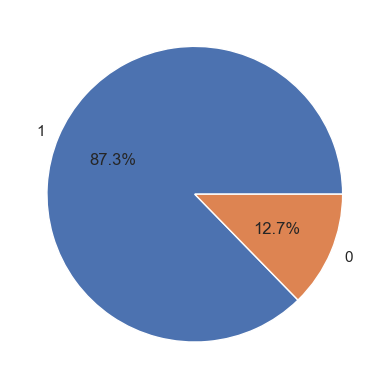

In [409]:
# plot the percentage of late payments
plt.pie(open_pred_df['PREDICT_LATE_PAYMENT'].value_counts(), labels= open_pred_df['PREDICT_LATE_PAYMENT'].value_counts().index, autopct='%1.1f%%')
plt.show()

> Out of ~60k Invoices predicted, there are 87% of Invoices that predicted as will be late.